In [3]:
# ======================
# 1. IMPORTS
# ======================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.linear_model import LinearRegression

In [4]:
# ======================
# 2. LOAD AND PREPARE DATA
# ======================

# Load your dataset
df = pd.read_csv('../raw_data/all_clean_weather_1984_2024_filtered.csv', parse_dates=['DATE'])  # <-- UPDATE your file path if needed

# Rename columns
df.rename(columns={
    'TX': 'max_temperature',
    'TM': 'avg_temperature',
    'TN': 'min_temperature',
    'NOM_USUEL': 'location',
    'LAT': 'lat',
    'LON': 'lon',
    'DATE': 'DATE',
    'RR': 'amount_precipitation',
    'Co2 Mole fraction (ppm)': 'co2',
    'Methane ppm': 'ch4'
}, inplace=True)

# First replace ',' by '.' then convert to float
df['co2'] = df['co2'].str.replace(',', '.').astype(float)
df['ch4'] = df['ch4'].str.replace(',', '.').astype(float)

# Extract year and month
df['year'] = df['DATE'].dt.year
df['month'] = df['DATE'].dt.month

# Monthly aggregation
monthly_df = df.groupby(['location', 'year', 'month']).agg({
    'avg_temperature': 'mean',
    'lat': 'first',
    'lon': 'first',
    'amount_precipitation': 'mean',
    'co2': 'mean',
    'ch4': 'mean'
}).reset_index()

# Add helper columns
monthly_df['years_since_1984'] = monthly_df['year'] - 1984
monthly_df['year_month'] = pd.to_datetime(
    monthly_df['year'].astype(str) + '-' + monthly_df['month'].astype(str) + '-01'
)

In [5]:
# ======================
# 3. TRAIN LINEAR MODEL
# ======================

# Choose your location
chosen_location = 'AJACCIO'  # <-- Change if needed

# Filter for chosen location
location_df = monthly_df[monthly_df['location'] == chosen_location]

# Define features and target
features = ['years_since_1984', 'co2', 'ch4']
X = location_df[features]
y = location_df['avg_temperature']

# Train the linear model
model = LinearRegression()
model.fit(X, y)

print("Model coefficients:", model.coef_)
print("Model intercept:", model.intercept_)

Model coefficients: [-0.05841318  0.03258452  7.18365862]
Model intercept: -8.28368774826155


In [6]:
# ======================
# 4. BUILD FUTURE INPUT
# ======================

# Setup
current_year = datetime.date.today().year
years_ahead = 20
future_years = range(current_year, current_year + years_ahead)

# Calculate CO₂/CH₄ slopes from historical data
annual_means = df.groupby('year').agg({'co2': 'mean', 'ch4': 'mean'}).reset_index()
co2_slope, co2_intercept = np.polyfit(annual_means['year'], annual_means['co2'], 1)
ch4_slope, ch4_intercept = np.polyfit(annual_means['year'], annual_means['ch4'], 1)

# Starting points (average 2024 CO2/CH4)
co2_2024 = df[df['year'] == 2024]['co2'].mean()
ch4_2024 = df[df['year'] == 2024]['ch4'].mean()

# Build future feature dataframe
future_data = {
    'years_since_1984': [],
    'co2': [],
    'ch4': [],
    'year': []
}

for year in future_years:
    years_since_1984 = year - 1984
    years_after_2024 = year - 2024
    est_co2 = co2_2024 + years_after_2024 * co2_slope
    est_ch4 = ch4_2024 + years_after_2024 * ch4_slope

    future_data['years_since_1984'].append(years_since_1984)
    future_data['co2'].append(est_co2)
    future_data['ch4'].append(est_ch4)
    future_data['year'].append(year)

future_input_df = pd.DataFrame(future_data)

In [7]:
# ======================
# 5. PREDICT FUTURE TEMPERATURES
# ======================

# Predict using linear model
future_input_features = future_input_df[['years_since_1984', 'co2', 'ch4']]
future_predictions = model.predict(future_input_features)

future_input_df['predicted_temperature'] = future_predictions

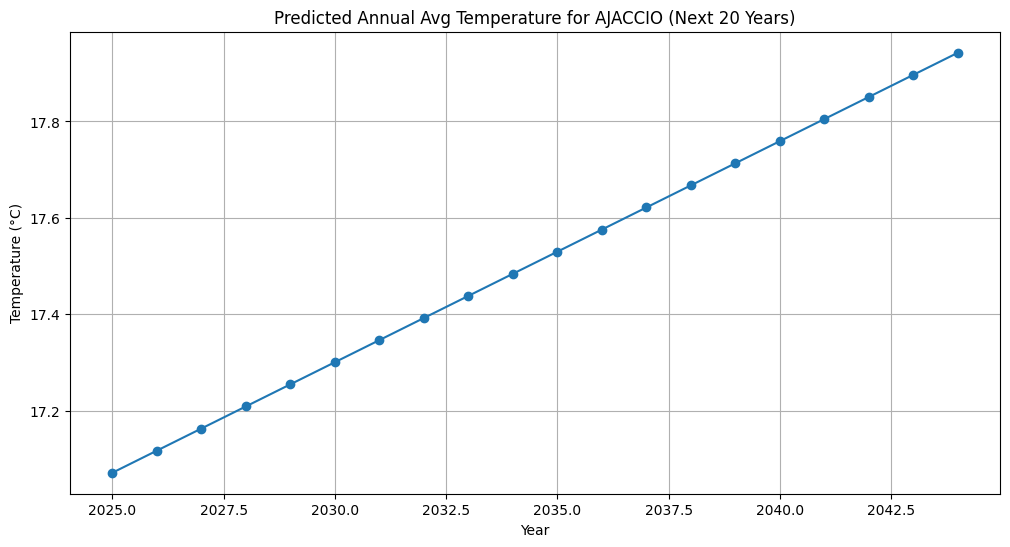

In [8]:
# ======================
# 6. PLOT RESULTS
# ======================

plt.figure(figsize=(12,6))
plt.plot(future_input_df['year'], future_input_df['predicted_temperature'], marker='o')
plt.title(f"Predicted Annual Avg Temperature for {chosen_location} (Next {years_ahead} Years)")
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.show()